# Comparación de palabras iguales en poemas con emociones diferentes.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from nltk.tokenize import word_tokenize
import nltk
import we_to_signal as wes

[nltk_data] Downloading package punkt to /home/ulises/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ulises/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Con los poemas separados, los metemos en un diccionario de dataframes
import os

data_path = "data/"
emotion_list = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]

json_files = sorted([pos_json for pos_json in os.listdir(data_path) if pos_json.endswith('.json')])
json_files.remove('Poems.json')
json_files.remove('missing.json')

em_poems = {}
for e in emotion_list:
    f = open(data_path+e+".json")
    df_ = pd.DataFrame(json.load(f))
    em_poems[e] = df_
em_poems["anger"]

,poem,id
0,i do know this it's nothing i can hold\nlast ...,10
1,the fear o' hell's a hangman's whip\nto haud t...,18
2,but since i laid a hand thereon\nand found a h...,88
3,falsely i pointed to sum in text\nseriously he...,99
4,i'll wear my jealous reflection\njuice of lemo...,125
...,...,...
2461,new snow on a leaf\nlike granulated sugar\nmak...,93124
2462,new earth and old earth\na trio of guardians\n...,93138
2463,destructions despair\nconstructions hope toge...,93217
2464,hot dry summers will\nbake paint right off the...,93226


In [4]:
#Carga de embeddings
from gensim.models import Word2Vec
from gensim.models import FastText

emotion_list = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]

poems_w2v = {}
poems_fst = {}

for e in emotion_list:
    w2v_lines = Word2Vec.load("embeddings_poems/w2v_model_"+e)
    fst_lines = FastText.load("embeddings_poems/fst_model_"+e)
    poems_w2v[e] = w2v_lines
    poems_fst[e] = fst_lines

In [5]:
emotion_a = "anger"
emotion_b = "anticipation"

mw2v_a = poems_w2v[emotion_a]
mfst_a = poems_fst[emotion_a]

mw2v_b = poems_w2v[emotion_b]
mfst_b = poems_fst[emotion_b]

In [26]:
def common_word(model_a,model_b)->list:
    """
    Create a list of common word in two gensim models.

    Parameters
    -------------
    model_a: Gensim model (fst or w2v).
    model_b: Gensim model (fst or w2v).

    Returns
    --------------
    list: List with common words between the models.
    """
    model_a_dict = model_a.wv.key_to_index
    model_b_dict = model_b.wv.key_to_index

    common_words = []
    for key in list(model_a_dict.keys()):
        if key in model_b_dict:
            common_words.append(key)
    
    return common_words

common_words_w2v = common_word(mw2v_a,mw2v_b)
common_words_fst = common_word(mfst_a,mfst_b)

In [25]:
def get_vectors(words:list,model)->list:
    """
    Calculate the embeddings of a list of strings gived a model.

    Parameters
    ------------
    words: List with strings.
    model: gensim model(fst or w2v)
    
    Returns
    ------------
    list: List with tuples of [word,vector].
    """

    vectors = []
    for word in words:
        vectors.append((word,model.wv.get_vector(word)))
    return vectors

1760

In [76]:
def build_words_vectors_data(common_words:list,model_a,model_b)->pd.DataFrame:
    """
    Creates a Dataframe with columns [words, embbeding_model_a, embbeding_model_b]
    
    Parameters
    ------------
    common_words: list with common word between models.
    model_a: gensim model (fastext or w2v).
    model_b: gensim model (fastext or w2v).
    """

    data = {}
    data["words"] = common_words.copy()
    data["embbeding_model_a"] = []
    data["embbeding_model_b"] = []

    for word in common_words:
        data["embbeding_model_a"].append(model_a.wv.get_vector(word,norm=True))
        data["embbeding_model_b"].append(model_b.wv.get_vector(word,norm=True))

    return pd.DataFrame(data)

In [77]:
data_w2v = build_words_vectors_data(common_words_w2v,mw2v_a,mw2v_b)
data_fst = build_words_vectors_data(common_words_fst,mfst_a,mfst_b)

display(data_w2v)
display(data_fst)

,words,embbeding_model_a,embbeding_model_b
0,the,"[-0.074571356, 0.09888577, -0.035351947, 0.058...","[-0.12992264, 0.09067258, 0.0016633858, 0.0660..."
1,and,"[-0.076016836, 0.09836932, -0.0359653, 0.05484...","[-0.09529541, 0.14158711, 0.007732343, -0.0349..."
2,of,"[-0.07567521, 0.09813196, -0.037018374, 0.0551...","[-0.103375435, 0.124761075, -0.009955226, 0.01..."
3,a,"[-0.07517576, 0.09953175, -0.03721849, 0.05452...","[-0.10672734, 0.12793517, 0.005556323, 0.00644..."
4,to,"[-0.0747832, 0.09769986, -0.036672354, 0.05156...","[-0.041993607, 0.20082001, 0.0009315059, -0.09..."
...,...,...,...
8265,martyrs,"[-0.11708717, 0.18000051, -0.07979874, 0.10236...","[-0.09172351, 0.028397692, -0.036259986, -0.01..."
8266,elation,"[-0.056189828, 0.09017971, 0.060131565, 0.1171...","[0.043908708, 0.030624766, -0.10485483, 0.0380..."
8267,afternoons,"[0.060429826, -0.12160156, 0.07337983, -0.1498...","[-0.10714079, 0.15676244, 0.06014968, 0.108518..."
8268,gibberish,"[-0.009315444, 0.05983702, -0.09838189, 0.1613...","[-0.022979211, 0.18154301, -0.033790972, -0.00..."


,words,embbeding_model_a,embbeding_model_b
0,the,"[0.05892307, 0.038402352, -0.075489864, 0.0635...","[0.043330193, -0.010277707, -0.16763657, -0.00..."
1,and,"[0.059186235, 0.039017975, -0.073899955, 0.064...","[0.013457333, 0.028681222, -0.09165401, -0.027..."
2,of,"[0.061216712, 0.039325263, -0.075887546, 0.063...","[-0.009552455, 0.03292888, -0.0690358, -0.0304..."
3,a,"[0.059903935, 0.038734823, -0.07522733, 0.0629...","[0.03983606, 0.010796906, -0.09718523, -0.0059..."
4,to,"[0.060684998, 0.03858779, -0.07509665, 0.06213...","[0.074966714, 0.01745066, -0.041270588, 0.0064..."
...,...,...,...
1755,fortunes,"[0.060194585, 0.038032826, -0.07509847, 0.0634...","[0.047516268, 0.010357625, -0.06097739, 0.0037..."
1756,release,"[0.061862584, 0.03776, -0.07397126, 0.06235046...","[0.06364246, 0.003003505, -0.052978072, 0.0139..."
1757,decide,"[0.059682563, 0.039320666, -0.07605457, 0.0621...","[0.054955315, 0.008287174, -0.05922585, 0.0076..."
1758,bridges,"[0.060322605, 0.038319036, -0.074086666, 0.063...","[0.03656169, 0.013152264, -0.066844985, -0.003..."


In [102]:
word = "decide"

word_data = data_fst[data_fst["words"]==word]
word_data

,words,embbeding_model_a,embbeding_model_b
1757,decide,"[0.059682563, 0.039320666, -0.07605457, 0.0621...","[0.054955315, 0.008287174, -0.05922585, 0.0076..."


In [107]:
print(word_data["embbeding_model_a"].values)

[array([ 0.05968256,  0.03932067, -0.07605457,  0.06219059,  0.04237527,
         0.18573347, -0.04779817,  0.19055067,  0.04030401, -0.16760239,
         0.13179225, -0.03452266, -0.02259246,  0.26285967, -0.0011227 ,
        -0.0333759 ,  0.04991298, -0.00171735, -0.10758987, -0.19714937,
        -0.21013129, -0.06217173, -0.14196293, -0.11693762, -0.12649399,
        -0.10192464, -0.18544683, -0.07734164,  0.05101172,  0.09865967,
        -0.16763963,  0.04607027,  0.22954452,  0.01103521,  0.01231976,
         0.18393263, -0.02153738,  0.00745207, -0.04003495, -0.03932721,
         0.08609381, -0.10958977,  0.03965154, -0.20703709, -0.13224474,
        -0.04993557, -0.07661764, -0.01601541,  0.00040196,  0.03277457,
         0.02179432, -0.03269699,  0.04205593, -0.10546052, -0.02737043,
         0.06560864, -0.00944655,  0.02858227, -0.06508548, -0.03705196,
         0.02525579, -0.03851555,  0.00725331,  0.17806372, -0.09805916,
         0.17733137, -0.01588156, -0.02671615,  0.0

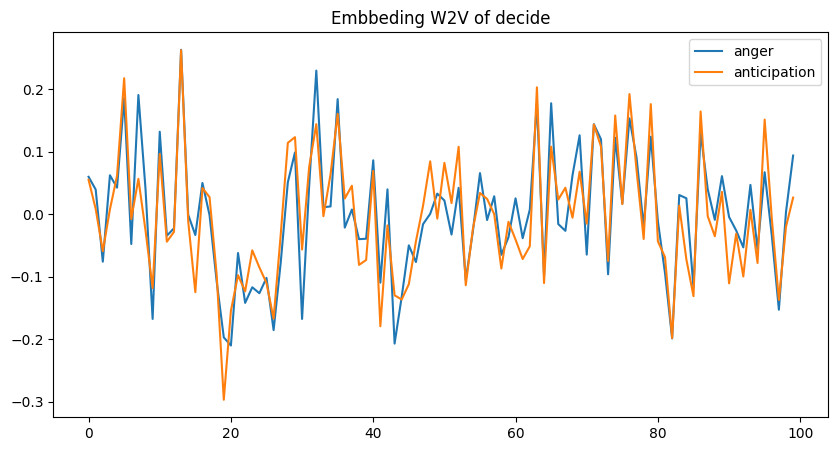

In [108]:
legend = [emotion_a,emotion_b]
plt.figure(figsize=(10,5))
plt.title("Embbeding W2V of "+word)
plt.plot(word_data["embbeding_model_a"].values[0])
plt.plot(word_data["embbeding_model_b"].values[0])
plt.legend(legend)

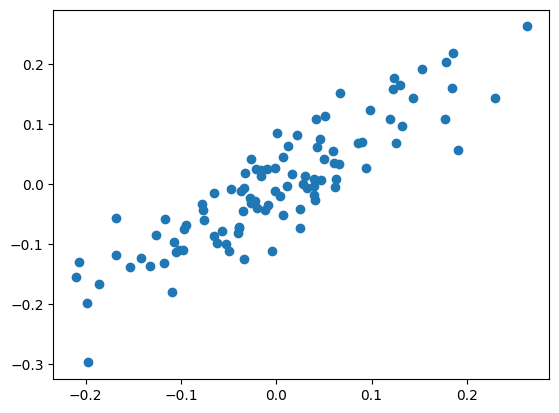

In [109]:
plt.scatter(word_data["embbeding_model_a"].values[0],word_data["embbeding_model_b"].values[0])

In [110]:
from scipy.stats import spearmanr
from scipy.stats import pearsonr

display(spearmanr(word_data["embbeding_model_a"].values[0],word_data["embbeding_model_b"].values[0]))
display(pearsonr(word_data["embbeding_model_a"].values[0],word_data["embbeding_model_b"].values[0]))

SignificanceResult(statistic=0.8857005700570055, pvalue=1.990993896020671e-34)

PearsonRResult(statistic=0.8872195912179981, pvalue=1.0734215660237406e-34)

In [118]:
set_ = set()
for emotion in emotion_list:
    fst = set(poems_fst[emotion].wv.key_to_index.keys())
    w2v = set(poems_fst[emotion].wv.key_to_index.keys())
    intersection = fst & w2v
    if not set_:
        set_ = set_.union(intersection)
    else:
        set_ = set_.intersection(intersection)

display(len(set_))
display(set_)

677

{'a',
 'about',
 'above',
 'across',
 'act',
 'after',
 'again',
 'against',
 'age',
 'ago',
 'ah',
 'air',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'always',
 'am',
 'among',
 'amp',
 'an',
 'ancient',
 'and',
 'angels',
 'another',
 'answer',
 'any',
 'are',
 'arms',
 'around',
 'as',
 'ask',
 'at',
 'away',
 'b',
 'back',
 'bare',
 'be',
 'bear',
 'beauty',
 'because',
 'become',
 'bed',
 'been',
 'before',
 'begin',
 'behind',
 'behold',
 'being',
 'beneath',
 'bent',
 'beside',
 'best',
 'better',
 'between',
 'beyond',
 'big',
 'bird',
 'birds',
 'bit',
 'black',
 'blind',
 'blood',
 'blow',
 'blue',
 'body',
 'book',
 'books',
 'born',
 'both',
 'bound',
 'bow',
 'brain',
 'branches',
 'bread',
 'break',
 'breast',
 'breath',
 'breathe',
 'breeze',
 'bright',
 'bring',
 'brought',
 'brown',
 'burn',
 'burst',
 'but',
 'by',
 'call',
 'called',
 'came',
 'can',
 'cant',
 'care',
 'cat',
 'chair',
 'cheek',
 'children',
 'city',
 'clay',
 'clear',
 'close',
 'c

In [121]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
set_ = set_ - stop_words
set_

{'across',
 'act',
 'age',
 'ago',
 'ah',
 'air',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'always',
 'among',
 'amp',
 'ancient',
 'angels',
 'another',
 'answer',
 'arms',
 'around',
 'ask',
 'away',
 'b',
 'back',
 'bare',
 'bear',
 'beauty',
 'become',
 'bed',
 'begin',
 'behind',
 'behold',
 'beneath',
 'bent',
 'beside',
 'best',
 'better',
 'beyond',
 'big',
 'bird',
 'birds',
 'bit',
 'black',
 'blind',
 'blood',
 'blow',
 'blue',
 'body',
 'book',
 'books',
 'born',
 'bound',
 'bow',
 'brain',
 'branches',
 'bread',
 'break',
 'breast',
 'breath',
 'breathe',
 'breeze',
 'bright',
 'bring',
 'brought',
 'brown',
 'burn',
 'burst',
 'call',
 'called',
 'came',
 'cant',
 'care',
 'cat',
 'chair',
 'cheek',
 'children',
 'city',
 'clay',
 'clear',
 'close',
 'clouds',
 'cold',
 'color',
 'come',
 'comes',
 'cool',
 'could',
 'country',
 'course',
 'cried',
 'cries',
 'cry',
 'cup',
 'cut',
 'dark',
 'day',
 'days',
 'dead',
 'dear',
 'death',
 'deep',
 'died',
 'dim',